In [2]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /Users/adelehannotte/Pypsa-earth/pypsa-earth
Had to go 1 folder(s) up.


In [2]:
import netCDF4
fp= os.getcwd() +  "/resources/renewable_profiles/profile_hydro.nc"
nc = netCDF4.Dataset(fp)
nc['plant']

<class 'netCDF4._netCDF4.Variable'>
vlen plant(plant)
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (112,)

NOT THE BEST METHOD TO READ .NC FILE

In [17]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/renewable_profiles/profile_hydro.nc"
datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (plant: 112, time: 8760)
Coordinates:
  * plant    (plant) object '0' '1' '4' '6' '7' ... '127' '128' '129' '130'
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...

In [19]:
datas.coords['plant']

<xarray.DataArray 'plant' (plant: 112)>
array(['0', '1', '4', '6', '7', '10', '11', '13', '14', '16', '17', '18', '19',
       '21', '22', '24', '25', '27', '28', '29', '30', '31', '33', '35', '36',
       '37', '39', '40', '41', '42', '43', '44', '46', '48', '49', '50', '51',
       '52', '53', '54', '56', '59', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79',
       '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91',
       '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111', '112',
       '113', '114', '115', '116', '117', '118', '119', '120', '121', '122',
       '123', '124', '125', '126', '127', '128', '129', '130'], dtype=object)
Coordinates:
  * plant    (plant) object '0' '1' '4' '6' '7' ... '127' '128' '129' '130'

In [5]:
inflow=datas.data_vars['inflow']
inflow

<xarray.DataArray 'inflow' (plant: 112, time: 8760)>
[981120 values with dtype=float64]
Coordinates:
  * plant    (plant) object '0' '1' '4' '6' '7' ... '127' '128' '129' '130'
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00

data to dataframe

In [6]:
df=inflow.to_dataframe()
df

inflow
plant time                             
0     2013-01-01 00:00:00  5.764094e+07
      2013-01-01 01:00:00  5.827313e+07
      2013-01-01 02:00:00  5.944983e+07
      2013-01-01 03:00:00  5.999019e+07
      2013-01-01 04:00:00  5.982552e+07
...                                 ...
130   2013-12-31 19:00:00  1.251133e+08
      2013-12-31 20:00:00  1.056168e+08
      2013-12-31 21:00:00  7.153427e+07
      2013-12-31 22:00:00  4.534065e+07
      2013-12-31 23:00:00  3.576256e+07

[981120 rows x 1 columns]

No units, maybe in kW?? https://pypsa-eur.readthedocs.io/en/latest/preparation/build_hydro_profile.html 

# Bottom up: see what are the input of build_renewable_profile

GEBCO: General Bathymetric Chart of the Oceans

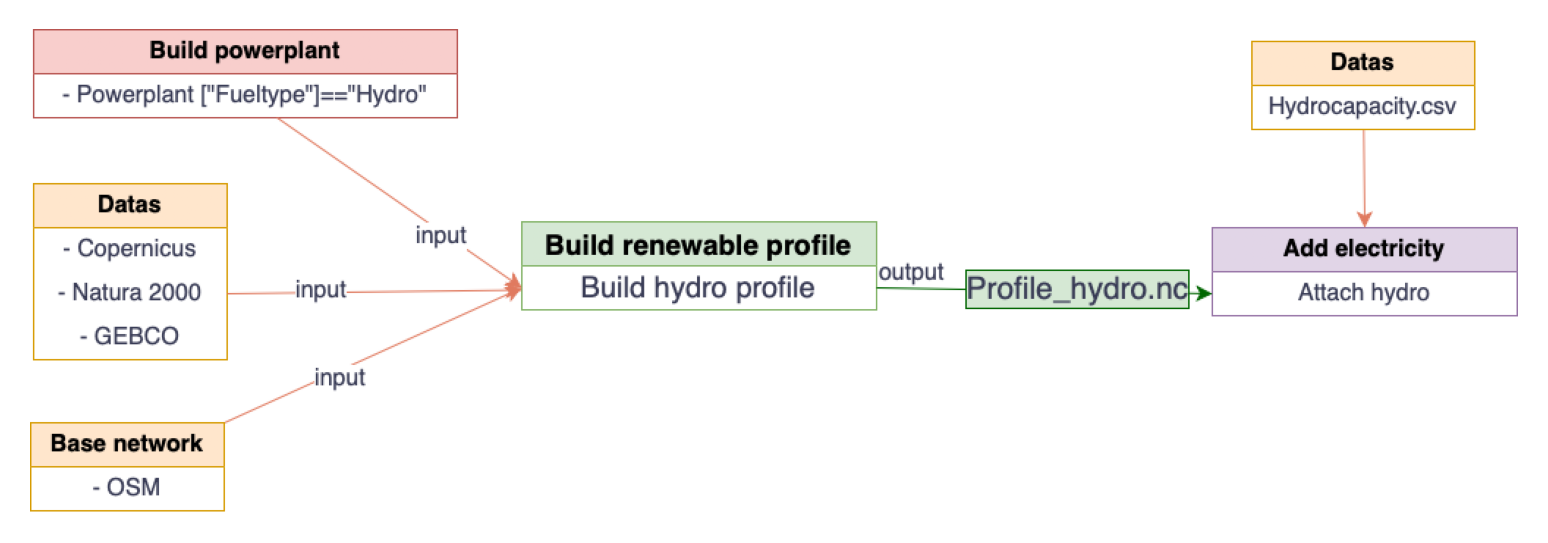

In [8]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/datas_for_hydro.drawio.png"))
#plt.show()

Gebco: hydrobassins 

In [7]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/data/gebco/GEBCO_2021_TID.nc"
datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (lon: 86400, lat: 43200)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Data variables:
    crs      |S1 ...
    tid      (lat, lon) int8 ...
Attributes: (12/31)
    title:                           The GEBCO_2021 Grid Type Identifier
    summary:                         The GEBCO_2021 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_lon_max:              180.0
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.004166666666666667
    identifier_product_doi:          DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    references:                      DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    node_offset:                     1.0

In [8]:
tid=datas.data_vars['tid']
tid

<xarray.DataArray 'tid' (lat: 43200, lon: 86400)>
[3732480000 values with dtype=int8]
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Attributes:
    long_name:           GEBCO Type Identifier
    units:               1.0
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::GEBCOSRC
    sdn_parameter_name:  Source identifer of GEBCO grid cell data
    sdn_uom_urn:         SDN:P06:UUUU
    sdn_uom_name:        Dimensionless
    flag_values:         [ 0 10 11 12 13 14 15 16 17 40 41 42 43 44 45 46 70 ...
    flag_meanings:       Land Singlebeam Multibeam Seismic Isolated_sounding ...

The TID grid identifies the type of source data that the corresponding grid cells in the GEBCO Grid are based on. 
More informations in https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2022/


In [9]:
df=tid.to_dataframe()
df

tid
lat        lon             
-89.997917 -179.997917    0
           -179.993750    0
           -179.989583    0
           -179.985417    0
           -179.981250    0
...                     ...
 89.997917  179.981250   41
            179.985417   41
            179.989583   41
            179.993750   41
            179.997917   41

[3732480000 rows x 1 columns]

Natura 2000

In [4]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/natura.tiff"
datas= xr.open_dataset(fp)
datas.data_vars['band_data']

#df=datas.data_vars['band_data'].to_dataframe()
#df

<xarray.DataArray 'band_data' (band: 1, y: 180402, x: 360771)>
[65083809942 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.804e+07 -1.804e+07 ... 1.804e+07 1.804e+07
  * y            (y) float64 9.02e+06 9.02e+06 9.02e+06 ... -9.02e+06 -9.02e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area

Copernicus = cutouts

In [4]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/cutouts/southamerica-2013-era5.nc"
datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:           (x: 45, y: 48, time: 8760)
Coordinates:
  * x                 (x) float64 -70.2 -69.9 -69.6 -69.3 ... -57.6 -57.3 -57.0
  * y                 (y) float64 -23.4 -23.1 -22.8 -22.5 ... -9.9 -9.6 -9.3
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables: (12/13)
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    wnd_azimuth       (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    ...                ...
    albedo            (time, y, x) float32 ...
    solar_altitude    (time, y, x) float64 ...
    solar_azimuth     (time, y, x) float64 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['wind', 'height', 'runoff', 'temperature', 'influx']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2023-03-09 14:52:54 GMT by grib_to_netcdf-2.25.1: /op...

In [5]:
df=datas.data_vars['runoff'].to_dataframe()
df

lon   lat    runoff
time                y     x                          
2013-01-01 00:00:00 -23.4 -70.2 -70.2 -23.4  0.000000
                          -69.9 -69.9 -23.4  0.000000
                          -69.6 -69.6 -23.4  0.000000
                          -69.3 -69.3 -23.4  0.000000
                          -69.0 -69.0 -23.4  0.000000
...                               ...   ...       ...
2013-12-31 23:00:00 -9.3  -58.2 -58.2  -9.3  0.000371
                          -57.9 -57.9  -9.3  0.000427
                          -57.6 -57.6  -9.3  0.000286
                          -57.3 -57.3  -9.3  0.000200
                          -57.0 -57.0  -9.3  0.000050

[18921600 rows x 3 columns]

Runoff occurs when there is more water than land can absorb

would need complex calculation to use this data

# Build_power_plant output (as input of build_renewable)

Graph of the dependencies for hydro build function

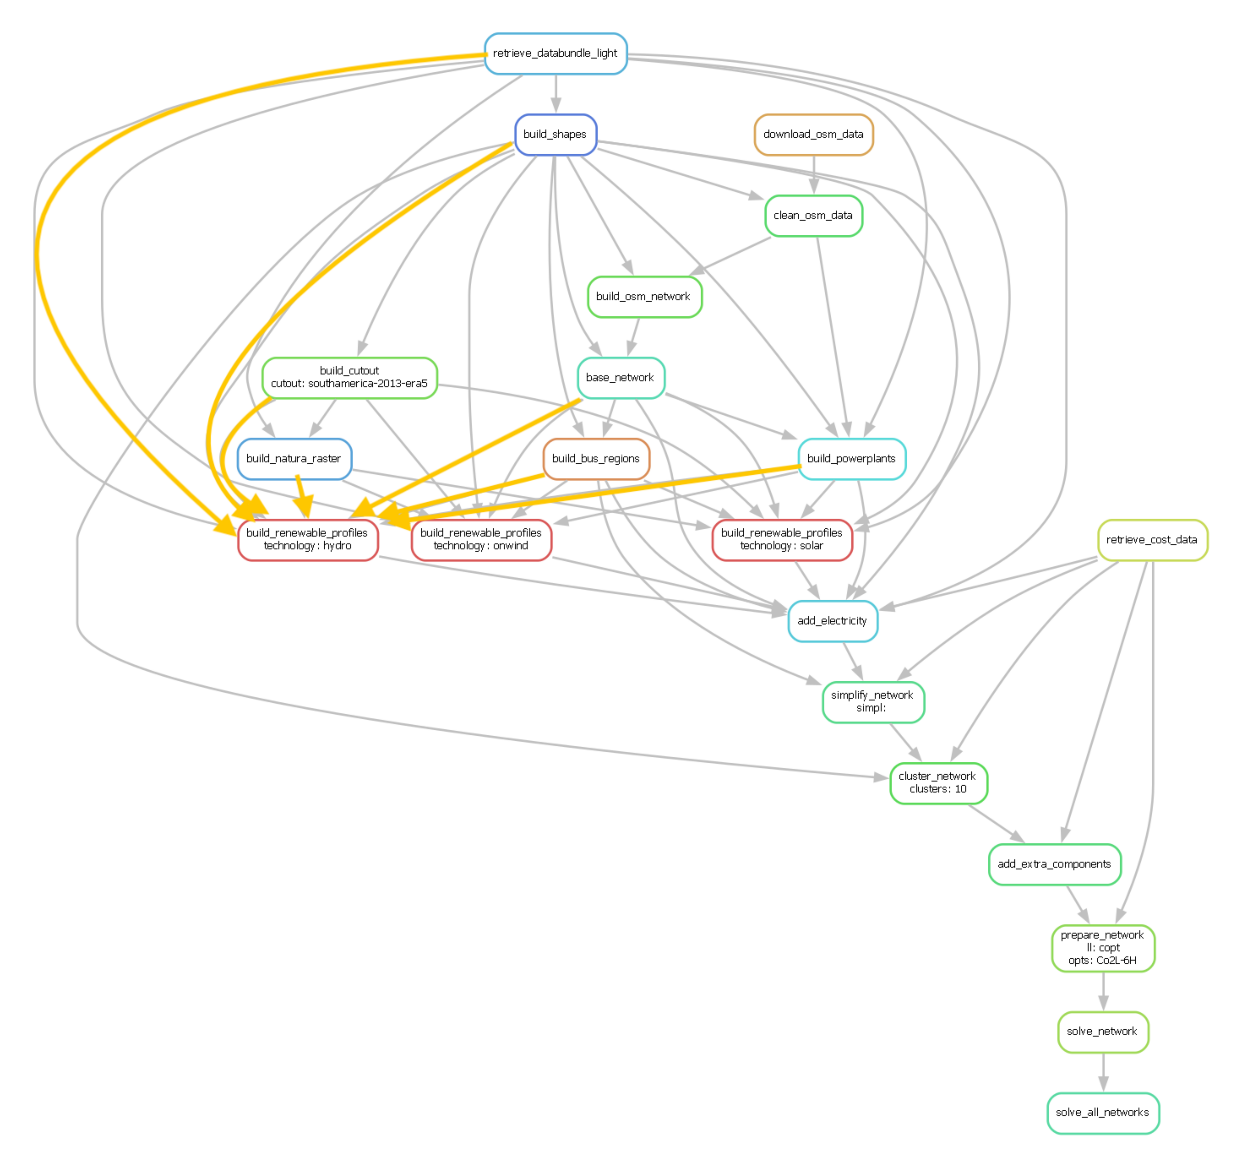

In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/workflow_hydro_dependencies.png"))
#plt.show()


In [1]:
powerplant = pd.read_csv(os.getcwd() +  "/resources/powerplants.csv")
powerplant
(powerplant)

NameError: name 'pd' is not defined

In [20]:
(powerplant[powerplant["Fueltype"]=="Hydro"])

13

# NB: there is 2 powerplant .csv files => no its a preprocessing file

In [54]:
powerplant = pd.read_csv(os.getcwd() +  "/resources/powerplants_osm2pm.csv")
powerplant

,Set,Type,Country,Name,Technology,Fueltype,Capacity,Efficiency,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,DateIn,DateRetrofit,DateMothball,DateOut,lat,lon,EIC,projectID
0,PP,Node,Bolivia,NaN,Onshore,Wind,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.628878,-65.284599,2503270686,OSM2503270686
1,PP,Node,Bolivia,NaN,Onshore,Wind,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.629786,-65.283500,2607448836,OSM2607448836
2,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.635373,-65.278620,5112046113,OSM5112046113
3,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.635676,-65.280361,5112046114,OSM5112046114
4,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.631718,-65.279334,5112046115,OSM5112046115
5,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.633746,-65.276845,5112046116,OSM5112046116
6,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.633465,-65.274634,5112046117,OSM5112046117
7,PP,Node,Bolivia,NaN,Onshore,Wind,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.629775,-65.274928,5112046118,OSM5112046118
8,PP,Node,Bolivia,VHE-08,CCGT,Natural Gas,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.430579,-66.116686,5123436490,OSM5123436490
9,PP,Node,Bolivia,VHE-07,CCGT,Natural Gas,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.430613,-66.116772,5123436491,OSM5123436491


In [55]:
powerplant[powerplant["Fueltype"]=="Hydro"]

,Set,Type,Country,Name,Technology,Fueltype,Capacity,Efficiency,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,DateIn,DateRetrofit,DateMothball,DateOut,lat,lon,EIC,projectID
35,PP,Way,Bolivia,NaN,Reservoir,Hydro,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.212192,-65.875706,208259012,OSM208259012
